In [ ]:
from implicit.nearest_neighbours import bm25_weight

# weight the matrix, both to reduce impact of users that have played the same artist thousands of times
# and to reduce the weight given to popular items
# artist_user_plays = bm25_weight(artist_user_plays, K1=100, B=0.8)

# get the transpose since the most of the functions in implicit expect (user, item) sparse matrices instead of (item, user)
user_plays = artist_user_plays.T.tocsr()

# CSR Matrix
- convert Book Interaction Data into CSR Matrix
- create class that performs id to index mapping, vice versa.

In [2]:
import pandas as pd
import numpy as np
from scipy import sparse
from pandas.api.types import CategoricalDtype

def df2interact_mat(df, user_col, item_col, interact_col):
    """
    Convert (user, item, interact) dataframe to sparse interaction matrix.
    REF: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html
    :param df: dataframe of (user, item, interact)
    :param user_col: (string) user_id column name
    :param item_col: (string) item_id column name
    :param interact_col: (string) interaction column name
    :return:
        interaction_sparse: (csr) interaction matrix
        users: (numpy array) user_id
        items: (numpy array) item_id
    """
    # Extract unique ids.
    users = np.array(list(np.sort(
        df[user_col].unique())))  # Get our unique users

    items = np.array(list(
        df[item_col].unique()))  # Get our unique items that were interacted with

    interactions = list(
        df[interact_col])  # All of our interactions

    # Re-code user and item index for sparse matrix.
    # Index starting from 0
    rows = df[user_col].astype(CategoricalDtype(
        categories=users)).cat.codes

    cols = df[item_col].astype(CategoricalDtype(
        categories=items)).cat.codes

    # Construct sparse matrix.
    # Get the associated column indices
    interaction_sparse = sparse.csr_matrix(
        (interactions, (rows, cols)), shape=(len(users), len(items))
    )

    return interaction_sparse, users, items

class IDMAP(object):
    """
    converts ids to indexes. vice versa.
    args:
        - entity_ids; list of real ids of the entities e.g item ids or user ids
    """
    def __init__(self, entity_ids):
        self.entity_ids = np.array(entity_ids)
        self.id_to_index_map = {v:k for k,v in enumerate(entity_ids)}
    def get_ids(self, indexes):
        return self.entity_ids[indexes]
    def get_indexes(self, ids):
        return [self.id_to_index_map[i] for i in ids]

In [3]:
path = r"C:\Users\tanch\Documents\NTU\NTU Year 4\Semester 1\CZ4125 - Developing Data Products\Assignments\Team Assignment - book recommendation\data\Ratings.csv\Ratings.csv"
data = pd.read_csv(path)
len(data['User-ID'].unique()),len(data['ISBN'].unique()), len(data)

(105283, 340556, 1149780)

In [4]:
interaction_sparse, users, items = df2interact_mat(df = data, user_col = 'User-ID', item_col = "ISBN", interact_col = "Book-Rating")

In [5]:
# get the interaction of the first user - the user interacted with 1 item, 8967
print(interaction_sparse[0])

  (0, 8967)	0


In [6]:
# get the actual id of the first user
users[0]

2

In [7]:
# get actual id of the interacted 
items[8967]

'0195153448'

In [8]:
# check that its correct - user 2 interacted with 0195153448 
data[data['User-ID']==users[0]]

,User-ID,ISBN,Book-Rating
9561,2,0195153448,0


# Alternating Least Squares Recommender
- trained recommender model
- recommend for user number 2

In [9]:
from implicit.als import AlternatingLeastSquares

config_dict = {
    "factors":32, 
    "regularization":0.05, 
    "alpha":2.0, 
    "iterations" : 15,
    "calculate_training_loss":False,
    "random_state":0
}

model = AlternatingLeastSquares(**config_dict)
model.fit(interaction_sparse)
model_path = r"C:\Users\tanch\Documents\NTU\NTU Year 4\Semester 1\CZ4125 - Developing Data Products\Assignments\Team Assignment - book recommendation\code\models\test0"
model.save(model_path)

C:\Users\tanch\anaconda3\envs\dp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 20%|████████████████▌                                                                  | 3/15 [00:59<03:56, 19.68s/it]


KeyboardInterrupt: 

In [10]:
user_map = IDMAP(users)
item_map = IDMAP(items)

In [11]:
item_indexes, scores = model.recommend(2, interaction_sparse[2])
item_indexes, scores

(array([1271, 3115, 1335, 1365, 1547, 2888, 2844, 1916,  641, 9976]),
 array([0.02153414, 0.01706984, 0.01696054, 0.01487165, 0.01333424,
        0.01284255, 0.01150127, 0.01130138, 0.01101576, 0.01072625],
       dtype=float32))

In [12]:
# these are the actual recommended books
item_map.get_ids(item_indexes)

array(['0452282152', '0440206154', '0679781587', '0312195516',
       '0385486804', '0385492081', '0446672211', '0671027360',
       '0446310786', '0060938455'], dtype='<U14')

In [13]:
data.sample(10)

,User-ID,ISBN,Book-Rating
625298,151702,0373700180,0
903379,218858,3442441382,6
168760,36836,0440060060,0
278490,65663,0446612545,0
738976,178522,0385497466,0
889906,214631,0786863137,7
1038001,248259,1575213052,10
106616,24462,8486311144,7
259516,60244,0064407055,8
430000,102705,0140257144,10


# Dataset processing
- process dataset 
    - take only users with at least 10 interactions
    - new interaction column, where are all ones (high ratings are given 2?) how does ALS work actually?
    - train-test-valid split


In [14]:
import pandas as pd
import numpy as np
from scipy import sparse
from pandas.api.types import CategoricalDtype

def df2interact_mat(df, user_col, item_col, interact_col):
    """
    Convert (user, item, interact) dataframe to sparse interaction matrix.
    REF: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html
    :param df: dataframe of (user, item, interact)
    :param user_col: (string) user_id column name
    :param item_col: (string) item_id column name
    :param interact_col: (string) interaction column name
    :return:
        interaction_sparse: (csr) interaction matrix
        users: (numpy array) user_id
        items: (numpy array) item_id
    """
    # Extract unique ids.
    users = np.array(list(np.sort(
        df[user_col].unique())))  # Get our unique users

    items = np.array(list(
        df[item_col].unique()))  # Get our unique items that were interacted with

    interactions = list(
        df[interact_col])  # All of our interactions

    # Re-code user and item index for sparse matrix.
    # Index starting from 0
    rows = df[user_col].astype(CategoricalDtype(
        categories=users)).cat.codes

    cols = df[item_col].astype(CategoricalDtype(
        categories=items)).cat.codes

    # Construct sparse matrix.
    # Get the associated column indices
    interaction_sparse = sparse.csr_matrix(
        (interactions, (rows, cols)), shape=(len(users), len(items))
    )

    return interaction_sparse, users, items

class IDMAP(object):
    """
    converts ids to indexes. vice versa.
    args:
        - entity_ids; list of real ids of the entities e.g item ids or user ids
    """
    def __init__(self, entity_ids):
        self.entity_ids = np.array(entity_ids)
        self.id_to_index_map = {v:k for k,v in enumerate(entity_ids)}
    def get_ids(self, indexes):
        return self.entity_ids[indexes]
    def get_indexes(self, ids):
        return [self.id_to_index_map[i] for i in ids]

In [15]:
path = r"C:\Users\tanch\Documents\NTU\NTU Year 4\Semester 1\CZ4125 - Developing Data Products\Assignments\Team Assignment - book recommendation\data\Ratings.csv\Ratings.csv"
data = pd.read_csv(path)
len(data['User-ID'].unique()),len(data['ISBN'].unique()), len(data)

(105283, 340556, 1149780)

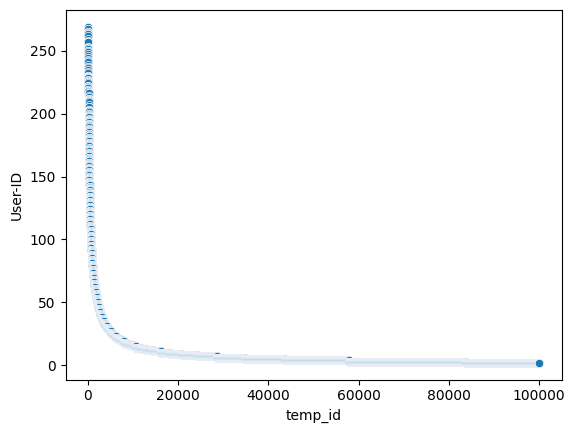

In [65]:
import seaborn as sb
def plot_num_interactions(df, main_col, sub_col):
    num_interactions_df = df.groupby(main_col).count().sort_values(by = sub_col, ascending = False)
    num_interactions_df['temp_id'] = range(len(num_interactions_df))
    num_interactions_df = num_interactions_df.reset_index()
    sb.scatterplot(data=num_interactions_df[100:100000] , x = "temp_id", y = sub_col)
plot_num_interactions(data, "ISBN", "User-ID")

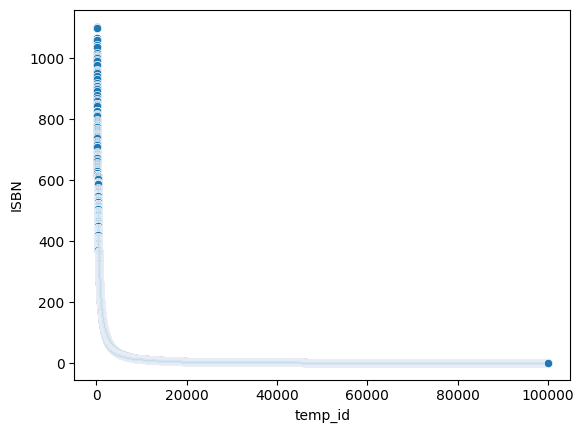

In [64]:
plot_num_interactions(data, "User-ID", "ISBN")

In [55]:
# all samples below minimum_interaction are removed
def filter_by_num_interactions(df, main_col, sub_col, minimum_interaction = 5):
    temp_df = df.groupby(main_col).count().reset_index()
    temp_df['num_interactions'] = temp_df[sub_col]
    temp_df = temp_df[[main_col, "num_interactions"]]
    df = df.merge(temp_df, on = main_col)
    df = df[df['num_interactions'] >= minimum_interaction].reset_index(drop = True)
    return df.iloc[:,:-1]

In [56]:
processed_data = filter_by_num_interactions(data, "User-ID", "ISBN", 5)
processed_data = filter_by_num_interactions(processed_data, "ISBN", "User-ID", 5)
processed_data.head()

,User-ID,ISBN,Book-Rating
0,276746,0425115801,0
1,276746,0449006522,0
2,276746,0553561618,0
3,276746,055356451X,0
4,276746,0786013990,0


In [60]:
len(data),len(processed_data)

(1149780, 608766)

In [19]:
# number of implicit interactions, number of explicit ratings
sum(data['Book-Rating']==0),sum(data['Book-Rating']>0)

(716109, 433671)

In [61]:
# the column contains all ones
def add_interaction_column(df):
    df['interaction'] = 1
    return df

In [62]:
processed_data = add_interaction_column(processed_data)
processed_data.head()

,User-ID,ISBN,Book-Rating,interaction
0,276746,0425115801,0,1
1,277427,0425115801,0,1
2,1660,0425115801,0,1
3,2288,0425115801,10,1
4,4938,0425115801,9,1


In [22]:
def train_test_split(df, train_frac = 0.9, seed = 0):
    df = df.sample(frac = 1, random_state = seed)
    train_end_index = int(train_frac*len(df))
    train, test = df[:train_end_index], df[train_end_index:]
    return train, test

In [23]:
train, test = train_test_split(processed_data)
len(train), len(test)

(869141, 96572)

# Retraining
- remove users and items with less than 10 interactions
- add interaction column i.e column with all ones
- convert interaction data into csr matrix
- split into train-test set

In [11]:
import pandas as pd
import numpy as np
from scipy import sparse
from pandas.api.types import CategoricalDtype
from implicit.als import AlternatingLeastSquares
from tqdm import tqdm
from random import sample
import pickle

def df2interact_mat(df, user_col, item_col, interact_col):
    """
    Convert (user, item, interact) dataframe to sparse interaction matrix.
    REF: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html
    :param df: dataframe of (user, item, interact)
    :param user_col: (string) user_id column name
    :param item_col: (string) item_id column name
    :param interact_col: (string) interaction column name
    :return:
        interaction_sparse: (csr) interaction matrix
        users: (numpy array) user_id
        items: (numpy array) item_id
    """
    # Extract unique ids.
    users = np.array(list(np.sort(
        df[user_col].unique())))  # Get our unique users

    items = np.array(list(
        df[item_col].unique()))  # Get our unique items that were interacted with

    interactions = list(
        df[interact_col])  # All of our interactions

    # Re-code user and item index for sparse matrix.
    # Index starting from 0
    rows = df[user_col].astype(CategoricalDtype(
        categories=users)).cat.codes

    cols = df[item_col].astype(CategoricalDtype(
        categories=items)).cat.codes

    # Construct sparse matrix.
    # Get the associated column indices
    interaction_sparse = sparse.csr_matrix(
        (interactions, (rows, cols)), shape=(len(users), len(items))
    )

    return interaction_sparse, users, items

class IDMAP(object):
    """
    converts ids to indexes. vice versa.
    args:
        - entity_ids; list of real ids of the entities e.g item ids or user ids
    """
    def __init__(self, entity_ids):
        self.entity_ids = np.array(entity_ids)
        self.id_to_index_map = {v:k for k,v in enumerate(entity_ids)}
    def get_ids(self, indexes):
        return self.entity_ids[indexes]
    def get_indexes(self, ids):
        return [self.id_to_index_map[i] for i in ids]
    
# all samples below minimum_interaction are removed
def filter_by_num_interactions(df, main_col, sub_col, minimum_interaction = 5):
    temp_df = df.groupby(main_col).count().reset_index()
    temp_df['num_interactions'] = temp_df[sub_col]
    temp_df = temp_df[[main_col, "num_interactions"]]
    df = df.merge(temp_df, on = main_col)
    df = df[df['num_interactions'] >= minimum_interaction].reset_index(drop = True)
    return df.iloc[:,:-1]

# the column contains all ones
def add_interaction_column(df):
    df['interaction'] = 1
    return df

def train_test_split(df, train_frac = 0.9, seed = 0):
    df = df.sample(frac = 1, random_state = seed)
    train_end_index = int(train_frac*len(df))
    train, test = df[:train_end_index], df[train_end_index:]
    return train, test

class BaseRecommender(object):
    def fit(self):
        raise NotImplementedError
    def recommend(self):
        raise NotImplementedError
        
class ALSRecommender(BaseRecommender):
    def __init__(self, config_dict, train_csr, user_map, item_map):
        
        self.config_dict = config_dict
        self.model = AlternatingLeastSquares(**self.config_dict)
        self.train_csr = train_csr
        self.user_map = user_map
        self.item_map = item_map
        super(ALSRecommender, self).__init__()
        
    def fit(self):
        self.model.fit(self.train_csr)
    def recommend(self, user_id, num_rec = 20, filtered_item_ids = []):
        user_index = self.user_map.get_indexes([user_id])[0]
        filtered_item_indexes = self.item_map.get_indexes(filtered_item_ids)
        recommended_items_index, scores = self.model.recommend(user_index, self.train_csr[user_index], num_rec, filter_items = filtered_item_indexes)
        recommended_item_ids = self.item_map.get_ids(recommended_items_index)
        return recommended_item_ids
    
        
    def load(self, path):
        self.model = self.model.load(path)
    def save(self, path):
        self.model.save(path)
        

         
# evaluate model over n samples from test set 
def evaluate(model, test_set, n = 1000, num_rec = 20):
    total_recall = 0 
    test_users = sample(test_set['User-ID'].unique().tolist(), n)
    for user_id in tqdm(test_users):
        ground_truth_item_ids = test_set.loc[test_set['User-ID']==user_id,"ISBN"].values.tolist()
        total_recall += evaluate_user(model, user_id, ground_truth_item_ids, num_rec)
    return total_recall/n
   
# evaluate model on 1 user
def evaluate_user(model, user_id, ground_truth_item_ids, num_rec = 20):
    # recommend items
    recommended_item_ids = model.recommend(user_id, num_rec)
    # compute metric 
    recall = compute_recall(ground_truth_item_ids, recommended_item_ids)
    return recall

# compute recall - fraction of recommended items that were relevant
def compute_recall(actual_items, predicted_items):
    actual_set = set(actual_items)
    predicted_set = set(predicted_items)
    return len(actual_set & predicted_set)/len(actual_set)

class PopRecommender(BaseRecommender):
    def fit(self, train):
        self.train = train
        self.memory = train.ISBN.value_counts().keys().tolist()
    def recommend(self, user_id, num_rec = 20, filtered_item_ids = []):
        remove_item_ids = self._get_user_liked_item_ids(user_id)
        remove_item_ids += filtered_item_ids
        candidates = self.memory
        for item_id in remove_item_ids:
            if item_id in candidates: 
                candidates.remove(item_id)
        return candidates[:num_rec]
        
    def _get_user_liked_item_ids(self, user_id):
        return self.train[self.train['User-ID'] == user_id].ISBN.tolist()
    
#     def save(self, path):
#         with open(path, "wb") as f:
#             pickle.dump(self.memory, f)
#     def load(self, path):
#         with open(path, "rb") as f:
#             self.memory = pickle.load(f)

In [5]:
path = r"C:\Users\tanch\Documents\NTU\NTU Year 4\Semester 1\CZ4125 - Developing Data Products\Assignments\Team Assignment - book recommendation\data\Ratings.csv\Ratings.csv"
data = pd.read_csv(path)

# remove samples with less than minimum_interaction
processed_data = filter_by_num_interactions(data, "User-ID", "ISBN", minimum_interaction = 10)
processed_data = filter_by_num_interactions(processed_data, "ISBN", "User-ID", minimum_interaction = 10)
processed_data = filter_by_num_interactions(processed_data, "User-ID", "ISBN", minimum_interaction = 10)
processed_data = filter_by_num_interactions(processed_data, "ISBN", "User-ID", minimum_interaction = 10)
# add column containing all ones
processed_data = add_interaction_column(processed_data)
# train_test_split
train, test = train_test_split(processed_data, train_frac = 0.7, seed = 0)
# convert to csr interaction matrix i.e input to model
train_csr, users, items = df2interact_mat(df = train, user_col = 'User-ID', item_col = "ISBN", interact_col = "interaction")
# retain a mapping between userids, itemids and their indexes in the recommender model
user_map = IDMAP(users)
item_map = IDMAP(items)

In [4]:
model_path = r"C:\Users\tanch\Documents\NTU\NTU Year 4\Semester 1\CZ4125 - Developing Data Products\Assignments\Team Assignment - book recommendation\code\models\test0"
config_dict = {
    "factors":64, 
    "regularization":0.01, 
    "alpha":1.0, 
    "iterations" : 20,
    "calculate_training_loss":True,
    "random_state":0
}

In [6]:
# train model
model = ALSRecommender(config_dict, train_csr, user_map, item_map)
model.fit()
# save model
model.save(model_path)

100%|████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.11it/s, loss=0.00218]


In [8]:
# load model
model = ALSRecommender(config_dict, interaction_sparse, user_map, item_map)
model = model.load(model_path)

C:\Users\tanch\anaconda3\envs\dp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
evaluate(model, test)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 927.70it/s]


0.06723219848735178

In [19]:
items_sorted_by_popularity = train.ISBN.value_counts().keys().tolist()

len(items_sorted_by_popularity)

13841

In [65]:
pop = PopRecommender()
pop.fit(train)

In [66]:
evaluate(pop, test)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 150.50it/s]


0.0057440578134798055